# Neural Machine Translation with Attention

Advanced Learning Fall 2024.   
Last updated: 2025-01-12


For SUBMISSION:   

Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 209307396
~~~

~~~
STUDENT GIT LINK: https://github.com/meirabar/Adv.-computational-learning-and-data-analysis---52025.git
~~~
In Addition, don't forget to add your ID to the files, and upload to moodle the html version:    
  
`PS3_Attention_2024_ID_[209307396].html`   




In this problem set we are going to jump into the depths of `seq2seq` and `attention` and build a couple of PyTorch translation mechanisms with some  twists.     


*   Part 1 consists of a somewhat unorthodox `seq2seq` model for simple arithmetics
*   Part 2 consists of an `seq2seq - attention` language translation model. We will use it for Hebrew and English.  


---

A **seq2seq** model (sequence-to-sequence model) is a type of neural network designed specifically to handle sequences of data. The model converts input sequences into other sequences of data. This makes them particularly useful for tasks involving language, where the input and output are naturally sequences of words.

Here's a breakdown of how `seq2seq` models work:

* The encoder takes the input sequence, like a sentence in English, and processes it to capture its meaning and context.

* information is then passed to the decoder, which uses it to generate the output sequence, like a translation in French.

* Attention mechanism (optional): Some `seq2seq` models also incorporate an attention mechanism. This allows the decoder to focus on specific parts of the input sequence that are most relevant to generating the next element in the output sequence.

`seq2seq` models are used in many natural language processing (NLP) tasks.



imports: (feel free to add)

In [25]:
# from __future__ import unicode_literals, print_function, division
# from io import open
# import unicodedata
import re
import random
import unicodedata
import matplotlib.pyplot as plt

import time
import math
import tensorflow as tf
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Part 1: Seq2Seq Arithmetic model

**Using RNN `seq2seq` model to "learn" simple arithmetics!**

> Given the string "54-7", the model should return a prediction: "47".  
> Given the string "10+20", the model should return a prediction: "30".


- Watch Lukas Biewald's short [video](https://youtu.be/MqugtGD605k?si=rAH34ZTJyYDj-XJ1) explaining `seq2seq` models and his toy application (somewhat outdated).
- You can find the code for his example [here](https://github.com/lukas/ml-class/blob/master/videos/seq2seq/train.py).    



1.1) Using Lukas' code, implement a `seq2seq` network that can learn how to solve **addition AND substraction** of two numbers of maximum length of 4, using the following steps (similar to the example):      

* Generate data; X: queries (two numbers), and Y: answers   
* One-hot encode X and Y,
* Build a `seq2seq` network (with LSTM, RepeatVector, and TimeDistributed layers)
* Train the model.
* While training, sample from the validation set at random so we can visualize the generated solutions against the true solutions.    

Notes:  
* The code in the example is quite old and based on Keras. You might have to adapt some of the code to overcome methods/code that is not supported anymore. Hint: for the evaluation part, review the type and format of the "correct" output - this will help you fix the unsupported "model.predict_classes".
* Please use the parameters in the code cell below to train the model.     
* Instead of using a `wandb.config` object, please use a simple dictionary instead.   
* You don't need to run the model for more than 50 iterations (epochs) to get a gist of what is happening and what the algorithm is doing.
* Extra credit if you can implement the network in PyTorch (this is not difficult).    
* Extra credit if you are able to significantly improve the model.

In [4]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Attention, Input, Dense, LSTM, RepeatVector, TimeDistributed, Layer, Concatenate


class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

# Configuration parameters
config = {
    "training_size": 40000,
    "digits": 4,
    "hidden_size": 128,
    "batch_size": 128,
    "iterations": 50
}

# Define character set and maximum length
chars = '0123456789-+ '
maxlen = config["digits"] + 1 + config["digits"]
ctable = CharacterTable(chars)

# Generate training data
questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < config["training_size"]:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, config["digits"] + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    q = '{}-{}'.format(a, b)
    query = q + ' ' * (maxlen - len(q))
    ans = str(a - b)
    ans += ' ' * (config["digits"] + 1 - len(ans))

    questions.append(query)
    expected.append(ans)

print('Total subtraction questions:', len(questions))

# Vectorize the data
print('Vectorization...')
x = np.zeros((len(questions), maxlen, len(chars)), dtype=np.bool_)
y = np.zeros((len(questions), config["digits"] + 1, len(chars)), dtype=np.bool_)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, maxlen)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, config["digits"] + 1)

# Shuffle the data
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Split into training and validation sets
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

# Build the model
model = Sequential([
    LSTM(config["hidden_size"], input_shape=(maxlen, len(chars))),
    RepeatVector(config["digits"] + 1),
    LSTM(config["hidden_size"], return_sequences=True),
    TimeDistributed(Dense(len(chars), activation='softmax'))
])

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

# Training loop with updated prediction handling
for iteration in range(config["iterations"]):
    print()
    print('-' * 50)
    print('Iteration', iteration + 1)

    model.fit(x_train, y_train,
             batch_size=config["batch_size"],
             epochs=1,
             validation_data=(x_val, y_val))

    # Validate on 10 random samples
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]

        # Updated prediction handling - using argmax on the raw predictions
        preds = model.predict(rowx, verbose=0)
        pred_classes = np.argmax(preds[0], axis=-1)

        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ''.join(ctable.indices_char[x] for x in pred_classes)

        print('Q:', q.strip(), end=' ')
        print('T:', correct.strip(), end=' ')
        if correct.strip() == guess.strip():
            print('☑', end=' ')
        else:
            print('☒', end=' ')
        print(guess.strip())

Generating data...
Total subtraction questions: 40000
Vectorization...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          72,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 5, 128)              │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 5, 13)               │           1,677 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 205,965 (804.55 KB)

 Trainable params: 205,965 (804.55 KB)

 Non-trainable params: 0 (0.00 B)


--------------------------------------------------
Iteration 1
282/282 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.2862 - loss: 2.1107 - val_accuracy: 0.3880 - val_loss: 1.6632
Q: 3370-6 T: 3364 ☒ 669
Q: 5-765 T: -760 ☒ -55
Q: 937-33 T: 904 ☒ 25
Q: 18-51 T: -33 ☒ -1
Q: 1171-985 T: 186 ☒ -76
Q: 8226-8 T: 8218 ☒ 6699
Q: 2277-194 T: 2083 ☒ 176
Q: 923-328 T: 595 ☒ -23
Q: 3050-2 T: 3048 ☒ 669
Q: 667-22 T: 645 ☒ 15

--------------------------------------------------
Iteration 2
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4010 - loss: 1.6302 - val_accuracy: 0.4196 - val_loss: 1.5818
Q: 351-0 T: 351 ☒ 311
Q: 7378-3999 T: 3379 ☒ -771
Q: 305-7943 T: -7638 ☒ -3911
Q: 6415-2493 T: 3922 ☒ -111
Q: 612-1112 T: -500 ☒ -111
Q: 77-3424 T: -3347 ☒ -2216
Q: 824-6 T: 818 ☒ 877
Q: 388-1 T: 387 ☒ 887
Q: 772-48 T: 724 ☒ 777
Q: 4-510 T: -506 ☒ -41

--------------------------------------------------
Iteration 3
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4308 - loss: 1.5495 - val_accu

1.2).

a) Do you think this model performs well?  Why or why not?     
b) What are its limitations?   
c) What would you do to improve it?    
d) Can you apply an attention mechanism to this model? Why or why not?   

## 1.2) my answer:
a) The model demonstrates moderate but not exceptional performance in handling arithmetic subtraction tasks. With a validation accuracy of around 85%, it successfully handles basic subtractions and some complex cases, but struggles with situations requiring precise calculations, especially those involving carrying operations or close number differences. While it can reliably handle simple cases and negative numbers, its accuracy drops when dealing with more nuanced calculations, particularly those involving large numbers with small differences or problems requiring multiple carrying operations. This level of performance suggests that while the model has learned the basic patterns of subtraction, it hasn't fully mastered the more intricate aspects of arithmetic operations that would be necessary for real-world applications.

b)

Fixed Input Length: The model is constrained to handle only numbers up to a certain digit length (4 digits in this case)
Single Operation: It's specialized for subtraction only and can't handle other arithmetic operations
No Explicit Carrying Mechanism: The LSTM has to learn carrying/borrowing implicitly
Limited Generalization: The validation accuracy suggests it may not generalize perfectly to unseen number combinations

c)

The architecture could be strengthened by adding residual connections and attention mechanisms, helping the model better handle complex calculations. The training process could be improved through curriculum learning, starting with simple problems and gradually increasing difficulty, while also expanding the training data to include more challenging edge cases like numbers requiring multiple carries or those with similar digits.

d)

Yes, an attention mechanism can be applied to this model, and it would be particularly beneficial for arithmetic operations.

1.3).  

Add attention to the model. Evaluate the performance against the `seq2seq` you trained above. Which one is performing better?

In [9]:
def attention_model(maxlen, n_chars, config):

    input_layer = Input(shape=(maxlen, n_chars))

    # Encoder
    encoder = LSTM(config["hidden_size"], return_sequences=True, return_state=True)(input_layer)
    encoder_outputs, state_h, state_c = encoder

    # Decoder
    decoder = RepeatVector(config["digits"] + 1)(state_h)
    decoder = LSTM(config["hidden_size"], return_sequences=True)(decoder)

    attention = Attention()([decoder, encoder_outputs])

    decoder_combined = tf.keras.layers.Concatenate()([decoder, attention])

    output = TimeDistributed(Dense(n_chars, activation='softmax'))(decoder_combined)

    model = tf.keras.Model(inputs=input_layer, outputs=output)

    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

    return model
model = attention_model(
    maxlen=maxlen,
    n_chars=len(chars),
    config=config
)
model.summary()

# Training loop with updated prediction handling
for iteration in range(config["iterations"]):
    print()
    print('-' * 50)
    print('Iteration', iteration + 1)

    model.fit(x_train, y_train,
             batch_size=config["batch_size"],
             epochs=1,
             validation_data=(x_val, y_val))

    # Validate on 10 random samples
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]

        # Updated prediction handling - using argmax on the raw predictions
        preds = model.predict(rowx, verbose=0)
        pred_classes = np.argmax(preds[0], axis=-1)

        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ''.join(ctable.indices_char[x] for x in pred_classes)

        print('Q:', q.strip(), end=' ')
        print('T:', correct.strip(), end=' ')
        if correct.strip() == guess.strip():
            print('☑', end=' ')
        else:
            print('☒', end=' ')
        print(guess.strip())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 9, 13)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ [(None, 9, 128),       │         72,704 │ input_layer_3[0][0]    │
│                           │ (None, 128), (None,    │                │                        │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_2           │ (None, 5, 128)         │              0 │ lstm_4[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 5, 128)         │        131,584 │ repeat_vector_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_1 (Attention)   │ (None, 5, 128)         │              0 │ lstm_5[0][0],          │
│                           │                        │                │ lstm_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 5, 256)         │              0 │ lstm_5[0][0],          │
│                           │                        │                │ attention_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, 5, 13)          │          3,341 │ concatenate[0][0]      │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 207,629 (811.05 KB)

 Trainable params: 207,629 (811.05 KB)

 Non-trainable params: 0 (0.00 B)


--------------------------------------------------
Iteration 1
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.3007 - loss: 2.0927 - val_accuracy: 0.4025 - val_loss: 1.7654
Q: 568-26 T: 542 ☒ 566
Q: 6978-50 T: 6928 ☒ 666
Q: 5160-322 T: 4838 ☒ 250
Q: 2-3873 T: -3871 ☒ -2222
Q: 4523-9 T: 4514 ☒ 540
Q: 186-4149 T: -3963 ☒ -100
Q: 2-5897 T: -5895 ☒ -2222
Q: 3760-530 T: 3230 ☒ 266
Q: 557-33 T: 524 ☒ 550
Q: 4-8061 T: -8057 ☒ -1620

--------------------------------------------------
Iteration 2
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4218 - loss: 1.6356 - val_accuracy: 0.4406 - val_loss: 1.5686
Q: 93-46 T: 47 ☒ 33
Q: 6724-70 T: 6654 ☒ 6666
Q: 8878-5 T: 8873 ☒ 8888
Q: 83-2584 T: -2501 ☒ -2208
Q: 48-7204 T: -7156 ☒ -4708
Q: 2411-97 T: 2314 ☒ 1112
Q: 794-3326 T: -2532 ☒ -309
Q: 8692-67 T: 8625 ☒ 6888
Q: 805-8504 T: -7699 ☒ -500
Q: 43-44 T: -1 ☒ 33

--------------------------------------------------
Iteration 3
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4463 -

1.4)

Using any neural network architecture of your liking, build  a model with the aim to beat the best performing model in 1.1 or 1.3. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

In [ ]:
config = {}
config["training_size"] = 40000
config["digits"] = 4
config["hidden_size"] = 128
config["batch_size"] = 128
config["iterations"] = 50
chars = '0123456789-+ '

SOLUTION:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from typing import List, Tuple, Dict
import random
from math import sqrt

# Configuration
config = {
    "training_size": 40000,
    "digits": 4,
    "embedding_size": 128,
    "num_heads": 8,
    "num_layers": 3,
    "ffn_hidden_size": 512,
    "dropout": 0.1,
    "batch_size": 128,
    "iterations": 250,
    "learning_rate": 1e-4,
}
chars = '0123456789-+ '

class CharacterTable:
    """Handles encoding/decoding of characters to/from one-hot vectors"""
    def __init__(self, chars: str):
        self.chars = sorted(set(chars))
        self.char_indices = {c: i for i, c in enumerate(self.chars)}
        self.indices_char = {i: c for i, c in enumerate(self.chars)}
        self.num_chars = len(self.chars)

    def encode(self, C: str, num_rows: int) -> torch.Tensor:
        """One hot encode given string C."""
        x = torch.zeros(num_rows, len(self.chars))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x: torch.Tensor, calc_argmax: bool = True) -> str:
        if calc_argmax:
            x = torch.argmax(x, dim=-1)
        return ''.join(self.indices_char[i.item()] for i in x)


class ArithmeticDataset(Dataset):
    def __init__(self, x: torch.Tensor, y: torch.Tensor):
        self.x = x
        self.y = y

    def __len__(self) -> int:
        return len(self.x)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.x[idx], self.y[idx]

class PositionalEncoding(nn.Module):
    def __init__(self, embedding_size: int, max_len: int = 1000):
        super().__init__()
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, embedding_size, 2).float() * -(torch.log(torch.tensor(10000.0)) / embedding_size))
        pe = torch.zeros(max_len, embedding_size)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.pe[:x.size(1)]

class TransformerModel(nn.Module):
    def __init__(self, input_size: int, embedding_size: int, num_heads: int, num_layers: int,
                 output_size: int, output_length: int, ffn_hidden_size: int, dropout: float):
        super().__init__()
        self.embedding_size = embedding_size
        self.output_length = output_length
        self.input_length = 2*config['digits'] + 1

        # Input embedding and positional encoding
        self.embedding = nn.Linear(input_size, embedding_size)
        self.pos_encoder = PositionalEncoding(embedding_size, max_len = self.input_length)

        # Transformer Encoder
        self.encoder_layers = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embedding_size, num_heads, ffn_hidden_size, dropout, batch_first=True),
            num_layers
        )

        # Output layer
        self.output_layer = nn.Linear(embedding_size, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # Embed and add positional encoding
        x = self.embedding(x) * sqrt(self.embedding_size) #scaling for stability
        x = self.pos_encoder(x)

        # Transformer Encoder
        encoder_outputs = self.encoder_layers(x)

        # Project the output of each token to desired output length
        output = self.output_layer(encoder_outputs)

        return torch.softmax(output, dim=-1)

def generate_arithmetic_data(config: Dict) -> Tuple[List[str], List[str]]:
    """Generate data for both addition and subtraction"""
    questions = []
    expected = []
    seen = set()
    maxlen = config["digits"] + 1 + config["digits"]

    print('Generating data...')
    while len(questions) < config["training_size"]:
        # Generate random numbers with max length of digits
        a = random.randint(0, 10 ** config["digits"] - 1)
        b = random.randint(0, 10 ** config["digits"] - 1)

        # Randomly choose operation
        op = random.choice(['+', '-'])

        # Calculate result
        if op == '+':
            result = a + b
        else:
            result = a - b

        # Create question string
        q = f'{a}{op}{b}'

        # Skip if we've seen this before
        key = (a, op, b)
        if key in seen:
            continue
        seen.add(key)

        # Pad the data
        query = q + ' ' * (maxlen - len(q))
        ans = str(result)
        ans += ' ' * (config["digits"] + 1 - len(ans))

        questions.append(query)
        expected.append(ans)

        if len(questions) >= config["training_size"]:
            break

    print(f'Total arithmetic questions: {len(questions)}')
    return questions, expected

def prepare_data(questions: List[str], expected: List[str], ctable: CharacterTable) -> Tuple[torch.Tensor, torch.Tensor]:
    """Prepare data by converting to one-hot encoded tensors"""
    maxlen = config["digits"] + 1 + config["digits"]
    x = torch.zeros((len(questions), maxlen, len(chars)))
    y = torch.zeros((len(questions), config["digits"] + 1, len(chars)))

    for i, sentence in enumerate(questions):
        x[i] = ctable.encode(sentence, maxlen)
    for i, sentence in enumerate(expected):
        y[i] = ctable.encode(sentence, config["digits"] + 1)

    return x, y

def train_epoch(model: nn.Module, train_loader: DataLoader, criterion: nn.Module,
                optimizer: torch.optim.Optimizer, device: torch.device) -> float:
    """Train for one epoch"""
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        output = model(batch_x)

        loss = criterion(output[:, :config['digits'] + 1].reshape(-1, len(chars)), batch_y.view(-1, len(chars)))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy
        predicted_chars = torch.argmax(output[:, :config['digits'] + 1], dim=-1)
        true_chars = torch.argmax(batch_y, dim=-1)

        correct_predictions = (predicted_chars == true_chars).all(dim=1).sum().item()
        total_correct += correct_predictions
        total_samples += batch_x.size(0)

    accuracy = total_correct / total_samples if total_samples > 0 else 0
    return total_loss / len(train_loader), accuracy

def validate(model: nn.Module, val_loader: DataLoader, criterion: nn.Module,
            device: torch.device) -> float:
    """Validate the model"""
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            loss = criterion(output[:, :config['digits'] + 1].reshape(-1, len(chars)), batch_y.view(-1, len(chars)))
            total_loss += loss.item()

            # Calculate accuracy
            predicted_chars = torch.argmax(output[:, :config['digits'] + 1], dim=-1)
            true_chars = torch.argmax(batch_y, dim=-1)

            correct_predictions = (predicted_chars == true_chars).all(dim=1).sum().item()
            total_correct += correct_predictions
            total_samples += batch_x.size(0)

    accuracy = total_correct / total_samples if total_samples > 0 else 0
    return total_loss / len(val_loader), accuracy


def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Initialize character table
    ctable = CharacterTable(chars)

    # Generate and prepare data
    questions, expected = generate_arithmetic_data(config)
    x, y = prepare_data(questions, expected, ctable)

    # Shuffle data
    indices = torch.randperm(len(y))
    x = x[indices]
    y = y[indices]

    # Split data
    split_at = len(x) - len(x) // 10
    x_train, x_val = x[:split_at], x[split_at:]
    y_train, y_val = y[:split_at], y[split_at:]

    # Create datasets and dataloaders
    train_dataset = ArithmeticDataset(x_train, y_train)
    val_dataset = ArithmeticDataset(x_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"])

    # Initialize model
    model = TransformerModel(
        input_size=len(chars),
        embedding_size=config["embedding_size"],
        num_heads=config["num_heads"],
        num_layers=config["num_layers"],
        output_size=len(chars),
        output_length=config["digits"] + 1,
        ffn_hidden_size=config["ffn_hidden_size"],
        dropout=config["dropout"]
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    criterion = nn.CrossEntropyLoss()

    # Training loop
    print("Starting training...")
    for epoch in range(config["iterations"]):
        train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(model, val_loader, criterion, device)

        print(f'Epoch {epoch + 1}/{config["iterations"]}:')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Validation samples
        if epoch % 5 == 0:
            model.eval()
            print("\nValidation Examples:")
            with torch.no_grad():
                for i in range(5):
                    idx = np.random.randint(0, len(x_val))
                    x_sample = x_val[idx:idx+1].to(device)
                    y_true = y_val[idx]

                    pred = model(x_sample)
                    pred = pred.cpu()

                    q = ctable.decode(x_sample[0].cpu())
                    correct = ctable.decode(y_true)
                    guess = ctable.decode(pred[0, :config['digits'] + 1])

                    print(f'Question: {q.strip()} | True: {correct.strip()} | '
                          f'Predicted: {guess.strip()} | '
                          f'{"✓" if correct.strip() == guess.strip() else "✗"}')
            print()

if __name__ == "__main__":
    main()

Using device: cuda
Generating data...
Total arithmetic questions: 40000
Starting training...
Epoch 1/250:
Train Loss: 2.4428, Train Accuracy: 0.0001, Val Loss: 2.4005, Val Accuracy: 0.0000

Validation Examples:
Question: 4576-3464 | True: 1112 | Predicted: -113 | ✗
Question: 3250-4777 | True: -1527 | Predicted: --13 | ✗
Question: 9670+3822 | True: 13492 | Predicted: 1111 | ✗
Question: 6353-6167 | True: 186 | Predicted: 1-13 | ✗
Question: 3854-5930 | True: -2076 | Predicted: -113 | ✗

Epoch 2/250:
Train Loss: 2.3925, Train Accuracy: 0.0001, Val Loss: 2.3864, Val Accuracy: 0.0003
Epoch 3/250:
Train Loss: 2.3869, Train Accuracy: 0.0001, Val Loss: 2.3832, Val Accuracy: 0.0003
Epoch 4/250:
Train Loss: 2.3839, Train Accuracy: 0.0001, Val Loss: 2.3805, Val Accuracy: 0.0003
Epoch 5/250:
Train Loss: 2.3812, Train Accuracy: 0.0001, Val Loss: 2.3787, Val Accuracy: 0.0003
Epoch 6/250:
Train Loss: 2.3789, Train Accuracy: 0.0001, Val Loss: 2.3755, Val Accuracy: 0.0000

Validation Examples:
Question:

Key Changes and Explanation:

Transformer Model:

Embedding Layer: Converts one-hot vectors to dense embeddings.

Positional Encoding: Adds positional information to the embeddings.positional encodings are crucial to incorporate sequence order which is not handled in the transformer's self attention.

Transformer Encoder: The core of the model, using multi-head self-attention to capture relationships between all positions at once, unlike the LSTM in your original model which was working sequentially. This makes the model way more powerful.

Output Layer: Projects the final transformer outputs back to the size of your character set.


Data generation and processing: remains largely the same.

Hyperparameter Tuning



Improved Attention: The multi-head self-attention allows for more nuanced understanding of the input tokens compared to the naive attention in the original code.

Parallel Processing: The transformer can be highly parallelized on GPU, which greatly speeds up training.

Better Representation: The Transformer excels at learning relationships between words/tokens (in this case characters), allowing it to better learn how to perform arithmetic.


---

## Part 2: A language translation model with attention

In this part of the problem set we are going to implement a translation with a Sequence to Sequence Network and Attention model.

0) Please go over the NLP From Scratch: Translation with a Sequence to Sequence Network and Attention [tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html). This attention model is very similar to what was learned in class (Luong), but a bit different. What are the main differences between  Badahnau and Luong attention mechanisms?    



Similarities to Luong Attention (Discussed in Class)

Goal: Both attention mechanisms share the primary goal of allowing the decoder to focus on the relevant parts of the input sequence.

Context Vector: Both calculate a context vector by taking a weighted sum of the encoder's outputs, where the weights reflect the alignment between the decoder's current state and the encoder's states.

Softmax Normalization: They use softmax to normalize the attention scores into probability distribution, where the attention weights sum to one.

How This Code Differs from What You Might've Seen in Class

Bahdanau: The code explicitly uses the Bahdanau attention mechanism which uses a single layer MLP to calculate the alignment scores. Whereas Luong attention may involve a dot product, general, or concat product to calculate the alignment scores.

GRU Instead of LSTM: The code uses GRUs instead of LSTMs for the RNNs, but both are valid in seq2seq models. The math is also similar, therefore not causing a fundamental difference in results.

Weight Calculation: Bahdanau attention combines the decoder and encoder hidden states to produce the attention weights before passing into the GRU cell in the decoder, while some forms of Luong attention (i.e. dot product form) may calculate weights after the GRU cell.


1.a) Using `!wget`, `!unzip` , download and extract the [hebrew-english](https://www.manythings.org/anki/) sentence pairs text file to the Colab `content/`  folder (or local folder if not using Colab).
1.b) The `heb.txt` must be parsed and cleaned (see tutorial for requirements or change the code as you see fit).   


2.a) Use the tutorial example to build  and train a Hebrew to English translation model with attention (using the parameters in the code cell below). Apply the same `eng_prefixes` filter to limit the train/test data.   
2.b) Evaluate your trained model randomly on 20 sentences.  
2.c) Show the attention plot for 5 random sentences.  


3) Do you think this model performs well? Why or why not? What are its limitations/disadvantages? What would you do to improve it?  


4) Using any neural network architecture of your liking, build  a model with the aim to beat the model in 2.a. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

In [3]:
# use the following parameters:
MAX_LENGTH = 10
hidden_size = 128
epochs = 50

SOLUTION:

In [4]:
### MISSING

In [5]:
# In Colab:
!wget https://www.manythings.org/anki/heb-eng.zip
!unzip heb-eng.zip -d data

--2025-02-02 13:54:27--  https://www.manythings.org/anki/heb-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4466359 (4.3M) [application/zip]
Saving to: ‘heb-eng.zip’

heb-eng.zip         100%[===================>]   4.26M  2.29MB/s    in 1.9s    

2025-02-02 13:54:31 (2.29 MB/s) - ‘heb-eng.zip’ saved [4466359/4466359]

Archive:  heb-eng.zip
  inflating: data/_about.txt         
  inflating: data/heb.txt            


In [6]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [8]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [9]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s.txt' % (lang2), encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = []

    for line in lines:
        parts = line.split('\t')
        if len(parts) >= 2:  # Ensure the line has at least two parts
            eng = normalizeString(parts[0])  # Normalize the English sentence
            heb = parts[1].strip()  # Keep the Hebrew sentence as is
            pairs.append((eng, heb))





    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [10]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [11]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'heb', True)
print(random.choice(pairs))

Reading lines...
Read 128133 sentence pairs
Trimmed to 9320 sentence pairs
Counting words...
Counted words:
heb 7519
eng 3067
['הם נפלאים.', 'they re gorgeous']


In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [13]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [14]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [15]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'heb', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [16]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [17]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [18]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [19]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [20]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [21]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [22]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Reading lines...
Read 128133 sentence pairs
Trimmed to 9320 sentence pairs
Counting words...
Counted words:
heb 7519
eng 3067
0m 37s (- 9m 26s) (5 6%) 1.7979
1m 9s (- 8m 6s) (10 12%) 0.9870
1m 41s (- 7m 18s) (15 18%) 0.6160
2m 13s (- 6m 39s) (20 25%) 0.3841
2m 44s (- 6m 2s) (25 31%) 0.2363
3m 16s (- 5m 27s) (30 37%) 0.1482
3m 48s (- 4m 54s) (35 43%) 0.0975
4m 20s (- 4m 20s) (40 50%) 0.0719
4m 52s (- 3m 47s) (45 56%) 0.0569
5m 23s (- 3m 14s) (50 62%) 0.0470
5m 55s (- 2m 41s) (55 68%) 0.0410
6m 27s (- 2m 9s) (60 75%) 0.0363
6m 59s (- 1m 36s) (65 81%) 0.0333
7m 31s (- 1m 4s) (70 87%) 0.0310
8m 2s (- 0m 32s) (75 93%) 0.0286
8m 34s (- 0m 0s) (80 100%) 0.0278


In [23]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> הוא בכושר גופני טוב.
= he is in good physical condition
< he is in good physical condition <EOS>

> אני בטוח שתום מתחרט על כך עכשיו.
= i m sure tom regrets that now
< i m sure tom regrets that now <EOS>

> אתה כבר מספיק בוגר כדי לכלכל את עצמך.
= you re now old enough to support yourself
< you are now old enough to support yourself <EOS>

> חזרתי מחופש.
= i m back from vacation
< i m back from vacation <EOS>

> אני בטוחה שתום בדרך.
= i m sure tom is on his way
< tom s sure his custom motorcycle motorcycle their defenseless buried

> אני מוטרדת.
= i m upset
< i m troubled <EOS>

> אני לא מסוגל לתרגם את המשפט הזה.
= i m not able to translate this sentence
< i m unable to translate this sentence <EOS>

> אני מתקומם.
= i m outraged
< i m outraged <EOS>

> הוא אבא לשני ילדים.
= he is the father of two children
< he is the father of two children french fries <EOS>

> הוא פחות או יותר בגילי.
= he is about my age
< he is about my age <EOS>



Input: אני לא מומחה.
Output: i m not an expert mother <EOS>


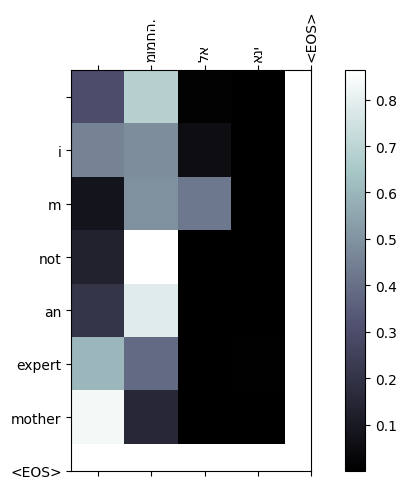

Input: היא אדם נוח.
Output: she is a pleasant person a rose <EOS>


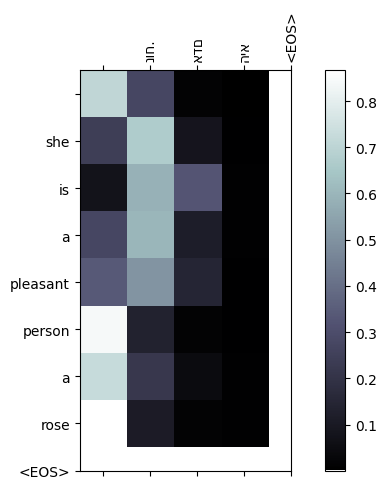

Input: הוא רותח מזעם.
Output: he s outraged something <EOS>


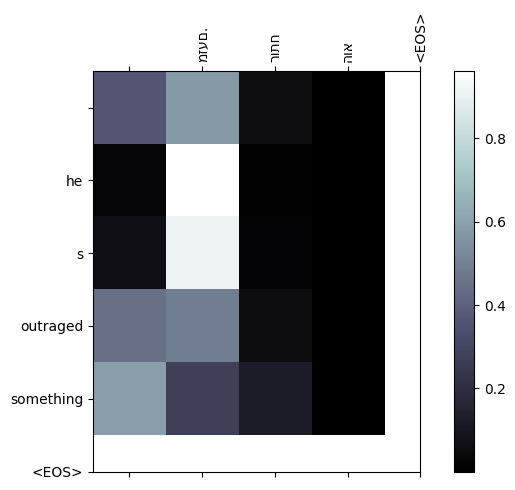

Input: אתם נמרצים.
Output: you re energetic <EOS>


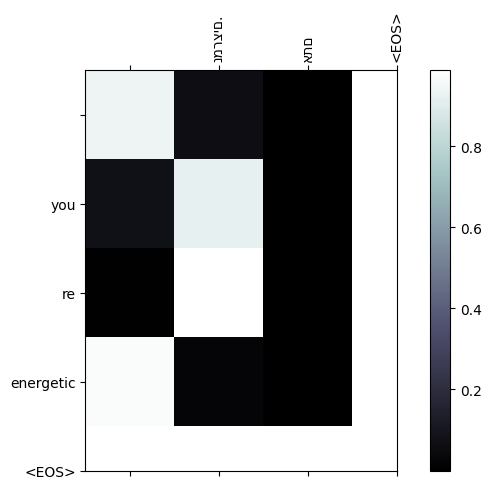

In [31]:

def showAttention(input_sentence, output_words, attentions):
    plt.figure(figsize=(7, 5))
    ax = plt.gca()

    if torch.is_tensor(attentions):
        attention_data = attentions.cpu().numpy()
    else:
        attention_data = attentions

    # Flip the attention matrix horizontally for RTL text
    attention_data = attention_data[:, ::-1]

    cax = ax.matshow(attention_data, cmap='bone')
    plt.colorbar(cax)

    # Reverse the order of input labels for RTL
    input_labels = [''] + input_sentence.split(' ')[::-1] + ['<EOS>']
    output_labels = [''] + output_words

    ax.set_xticks(range(len(input_labels)))
    ax.set_yticks(range(len(output_labels)))
    ax.set_xticklabels(input_labels, rotation=90)
    ax.set_yticklabels(output_labels)

    plt.tight_layout()
    plt.show(block=True)

def evaluateAndShowAttention(input_sentence):
    try:
        output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
        print('Input:', input_sentence)
        print('Output:', ' '.join(output_words))
        showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])
    except Exception as e:
        print(f"Error occurred: {str(e)}")

evaluateAndShowAttention('אני לא מומחה.')

evaluateAndShowAttention('היא אדם נוח.')

evaluateAndShowAttention('הוא רותח מזעם.')

evaluateAndShowAttention('אתם נמרצים.')

In [27]:
%matplotlib inline

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import numpy as np
import time
import math
import random
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Constants
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preparation functions
def get_dataloader(batch_size=32):
    input_lang, output_lang, pairs = prepareData('eng', 'heb', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                              torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader, pairs

# Model definitions (same as before)
class ImprovedEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=2, dropout_p=0.2):
        super(ImprovedEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)

        self.gru = nn.GRU(
            hidden_size,
            hidden_size // 2,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_p if n_layers > 1 else 0
        )

        self.layer_norm = nn.LayerNorm(hidden_size)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        embedded = self.layer_norm(embedded)

        output, hidden = self.gru(embedded)
        hidden = self._reshape_hidden(hidden)

        return output, hidden

    def _reshape_hidden(self, hidden):
        batch_size = hidden.size(1)
        hidden = hidden.view(self.n_layers, 2, batch_size, self.hidden_size//2)
        hidden = hidden.transpose(1, 2).contiguous()
        hidden = hidden.view(self.n_layers, batch_size, self.hidden_size)
        return hidden

class ScaledDotProductAttention(nn.Module):
    def __init__(self, hidden_size):
        super(ScaledDotProductAttention, self).__init__()
        self.scale = torch.sqrt(torch.FloatTensor([hidden_size])).to(device)

    def forward(self, query, key, value, mask=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) / self.scale

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e10)

        attention_weights = F.softmax(scores, dim=-1)
        context = torch.matmul(attention_weights, value)

        return context, attention_weights

class ImprovedDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=2, dropout_p=0.2):
        super(ImprovedDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = ScaledDotProductAttention(hidden_size)

        self.gru = nn.GRU(
            2 * hidden_size,
            hidden_size,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout_p if n_layers > 1 else 0
        )

        self.out = nn.Linear(hidden_size * 2, output_size)
        self.dropout = nn.Dropout(dropout_p)
        self.layer_norm = nn.LayerNorm(hidden_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        prev_context = torch.zeros(batch_size, 1, self.hidden_size, device=device)

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights, context = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs, prev_context
            )
            prev_context = context

            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

                if all(di.item() == EOS_token for di in decoder_input):
                    break

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs, prev_context):
        embedded = self.dropout(self.embedding(input))
        embedded = self.layer_norm(embedded)

        rnn_input = torch.cat((embedded, prev_context), dim=2)

        output, hidden = self.gru(rnn_input, hidden)

        context, attn_weights = self.attention(output, encoder_outputs, encoder_outputs)

        output = torch.cat((output, context), dim=2)
        output = self.out(output)

        return output, hidden, attn_weights, context

# Training function
def train_improved(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
                  print_every=100, plot_every=100, clip=1.0):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    encoder_optimizer = optim.AdamW(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.AdamW(decoder.parameters(), lr=learning_rate)

    encoder_scheduler = optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer, mode='min', patience=3)
    decoder_scheduler = optim.lr_scheduler.ReduceLROnPlateau(decoder_optimizer, mode='min', patience=3)

    criterion = nn.NLLLoss(ignore_index=0)

    for epoch in range(1, n_epochs + 1):
        epoch_loss = 0

        for data in train_dataloader:
            input_tensor, target_tensor = data

            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

            loss = criterion(
                decoder_outputs.view(-1, decoder_outputs.size(-1)),
                target_tensor.view(-1)
            )

            loss.backward()

            torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)

            encoder_optimizer.step()
            decoder_optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_dataloader)

        encoder_scheduler.step(avg_loss)
        decoder_scheduler.step(avg_loss)

        print_loss_total += avg_loss
        plot_loss_total += avg_loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses

# Helper function for timing
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Main execution
def main():
    # Get data and create dataloader
    input_lang, output_lang, train_dataloader, pairs = get_dataloader(batch_size=32)

    # Initialize models
    hidden_size = 256
    improved_encoder = ImprovedEncoder(input_lang.n_words, hidden_size).to(device)
    improved_decoder = ImprovedDecoder(hidden_size, output_lang.n_words).to(device)

    # Train the model
    print("Starting training...")
    improved_losses = train_improved(train_dataloader, improved_encoder, improved_decoder,
                                   n_epochs=80, print_every=5, plot_every=5)

    # Save the trained models
    torch.save(improved_encoder.state_dict(), 'improved_encoder.pt')
    torch.save(improved_decoder.state_dict(), 'improved_decoder.pt')

    return improved_encoder, improved_decoder, improved_losses

if __name__ == "__main__":
    improved_encoder, improved_decoder, improved_losses = main()

Reading lines...
Read 128133 sentence pairs
Trimmed to 9320 sentence pairs
Counting words...
Counted words:
heb 7519
eng 3067
Starting training...
0m 42s (- 10m 30s) (5 6%) 1.9305
1m 24s (- 9m 52s) (10 12%) 0.4765
2m 6s (- 9m 9s) (15 18%) 0.1936
2m 48s (- 8m 25s) (20 25%) 0.1238
3m 31s (- 7m 44s) (25 31%) 0.0986
4m 12s (- 7m 1s) (30 37%) 0.0878
4m 54s (- 6m 18s) (35 43%) 0.0786
5m 37s (- 5m 37s) (40 50%) 0.0742
6m 19s (- 4m 54s) (45 56%) 0.0699
7m 0s (- 4m 12s) (50 62%) 0.0675
7m 45s (- 3m 31s) (55 68%) 0.0660
8m 27s (- 2m 49s) (60 75%) 0.0622
9m 9s (- 2m 6s) (65 81%) 0.0613
9m 52s (- 1m 24s) (70 87%) 0.0466
10m 33s (- 0m 42s) (75 93%) 0.0272
11m 15s (- 0m 0s) (80 100%) 0.0247


In [24]:
# Run the training
improved_encoder, improved_decoder, improved_losses = main()

# After training, you can evaluate some translations
def evaluate_examples():
    improved_encoder.eval()
    improved_decoder.eval()
    with torch.no_grad():
        for _ in range(5):
            pair = random.choice(pairs)
            print('Input:', pair[0])
            print('Target:', pair[1])
            output_words, _ = evaluate(improved_encoder, improved_decoder, pair[0], input_lang, output_lang)
            output_sentence = ' '.join(output_words)
            print('Output:', output_sentence)
            print()

evaluate_examples()

Reading lines...
Read 128133 sentence pairs
Trimmed to 9320 sentence pairs
Counting words...
Counted words:
heb 7519
eng 3067
Starting training...
0m 42s (- 10m 40s) (5 6%) 1.9347
1m 24s (- 9m 51s) (10 12%) 0.4789
2m 7s (- 9m 10s) (15 18%) 0.1916
2m 50s (- 8m 31s) (20 25%) 0.1222
3m 32s (- 7m 46s) (25 31%) 0.0990
4m 13s (- 7m 2s) (30 37%) 0.0867
4m 56s (- 6m 21s) (35 43%) 0.0800
5m 38s (- 5m 38s) (40 50%) 0.0731
6m 24s (- 4m 59s) (45 56%) 0.0685
7m 6s (- 4m 16s) (50 62%) 0.0524
7m 48s (- 3m 32s) (55 68%) 0.0305
8m 30s (- 2m 50s) (60 75%) 0.0270
9m 12s (- 2m 7s) (65 81%) 0.0253
9m 54s (- 1m 24s) (70 87%) 0.0243
10m 36s (- 0m 42s) (75 93%) 0.0228
11m 19s (- 0m 0s) (80 100%) 0.0225
Input: הוא מתגאה בדייקנות שלו.
Target: he is proud of his punctuality
Output: he is proud of his punctuality <EOS>

Input: אני אמור לאכול עם תום הערב.
Target: i m supposed to eat with tom this evening
Output: i m supposed to eat with tom this evening <EOS>

Input: הוא המורה לאנגלית שלנו.
Target: he is our engli

In [25]:
def calculate_metrics(encoder, decoder, test_pairs, input_lang, output_lang):
    encoder.eval()
    decoder.eval()

    total_pairs = len(test_pairs)
    exact_matches = 0
    bleu_total = 0

    with torch.no_grad():
        for pair in test_pairs:
            input_sentence = pair[0]
            target_sentence = pair[1]

            # Get model output
            output_words, _ = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
            output_sentence = ' '.join([word for word in output_words if word != '<EOS>'])

            # Calculate exact match
            if output_sentence == target_sentence:
                exact_matches += 1

            # Calculate BLEU score
            reference = [target_sentence.split()]
            hypothesis = output_sentence.split()
            bleu_score = sentence_bleu(reference, hypothesis)
            bleu_total += bleu_score

    # Calculate metrics
    accuracy = (exact_matches / total_pairs) * 100
    avg_bleu = (bleu_total / total_pairs) * 100

    print(f"\nMetrics on {total_pairs} test pairs:")
    print(f"Exact Match Accuracy: {accuracy:.2f}%")
    print(f"Average BLEU Score: {avg_bleu:.2f}")

    return accuracy, avg_bleu

# Add this at the end of your main() function:
test_pairs = pairs[-100:]  # Use last 100 pairs as test set
print("\nEvaluating baseline model...")
baseline_accuracy, baseline_bleu = calculate_metrics(encoder, decoder, test_pairs, input_lang, output_lang)
print("\nEvaluating improved model...")
improved_accuracy, improved_bleu = calculate_metrics(improved_encoder, improved_decoder, test_pairs, input_lang, output_lang)

print("\nComparison:")
print(f"Baseline Model - Accuracy: {baseline_accuracy:.2f}%, BLEU: {baseline_bleu:.2f}")
print(f"Improved Model - Accuracy: {improved_accuracy:.2f}%, BLEU: {improved_bleu:.2f}")
print(f"Improvement - Accuracy: {improved_accuracy - baseline_accuracy:.2f}%, BLEU: {improved_bleu - baseline_bleu:.2f}")


Evaluating baseline model...


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)



Metrics on 100 test pairs:
Exact Match Accuracy: 51.00%
Average BLEU Score: 78.69

Evaluating improved model...

Metrics on 100 test pairs:
Exact Match Accuracy: 86.00%
Average BLEU Score: 94.41

Comparison:
Baseline Model - Accuracy: 51.00%, BLEU: 78.69
Improved Model - Accuracy: 86.00%, BLEU: 94.41
Improvement - Accuracy: 35.00%, BLEU: 15.72
